In [7]:
import pandas as pd
import yfinance as yf
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# import sys
# sys.path.append('..')
# from src.features.build_features import *

In [38]:
def stock_score(y_pred):
    """
    Returns the annual return of the predictions made by the algorithm,
    and the position history of the algorithm (used for plots).
    """

    ticker_df = yf.download('GLD', start='2004-01-01', end='2020-06-26')
    ticker_df['pct_change'] = 1 + ticker_df.Close.pct_change()
    ticker_df = ticker_df[1:]
    ticker_train = ticker_df[:int(len(ticker_df) * 0.8)]
    ticker_test = ticker_df[int((len(ticker_df)) * 0.8):]
    
    if len(y_pred) == len(ticker_train):
        stock = ticker_train
    elif len(y_pred) == len(ticker_test):
        stock = ticker_test
    else:
        raise IndexError(f'Not the length of test or train. Wrong series? {len(y_pred)}')

    position = 100
    history = []
    
    i = 0
    while i < len(y_pred):
        if y_pred[i] == 1:
            position *= stock['pct_change'][i]
        else:
            position /= stock['pct_change'][i]

        history.append(position)
        i += 1

    ann_return = ((1+((position - 100) / 100)) ** (1 / (len(y_pred)/365)) - 1) * 100

    return ann_return, history

In [43]:
%%capture

gold_etf = yf.download('GLD', start='2004-01-01', end='2020-06-26')
search = pd.read_csv('data/stock_market.csv')

<Axes: xlabel='Date', ylabel='Adj Close'>

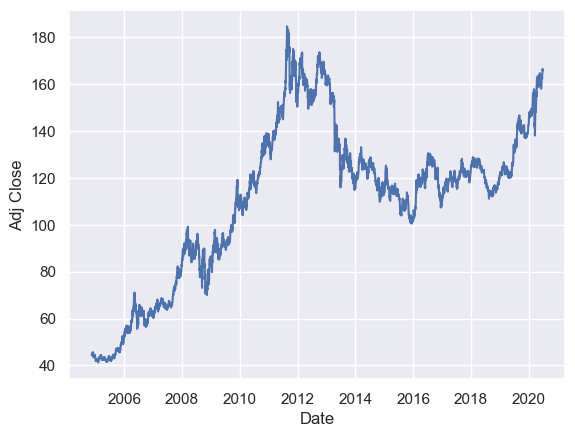

In [46]:
sns.lineplot(gold_etf['Adj Close'])

In [15]:

def research(series, length=3):
    """
    The feature which is also used in the research paper by Tobias Preis et al.

    Args:
        series (pandas.Series): Series of the Google Trends data.
        length (int, optional): Length of the moving average used in the
            calculation. Defaults to 3.

    Returns:
        pandas.Series: Series containing the feature.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    N = series.rolling(window=length).mean().shift(1)
    delta_n = series - N

    return delta_n


def delta(series, length=3):
    """
    Feature based on the delta between two values `length` away.

    Args:
        series (pandas.Series): Series of Google Trends data.
        length (int, optional): Difference between the two values of which the
            delta is calculated. Defaults to 3.

    Returns:
        pandas.Series: Series containing the feature.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    return series.diff(periods=length)


def pct_change(series, length=3):
    """
    Feature based on the percentage change between two values `length` away.

    Args:
        series (pandas.Series): Series of Google Trends data.
        length (int, optional): Percentage change between the two values of which
            the delta is calculated. Defaults to 3.

    Returns:
        pandas.Series: Series containing the feature.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    return series.pct_change(periods=length)


def sma(series, length=6):
    """
    Simple moving average.

    Args:
        series (pandas.Series): Series of Google Trends data.
        length (int, optional): Window of the moving average. Defaults to 6.

    Returns:
        pandas.Series: Series containing the feature.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    return series.rolling(window=length).mean()


def ema(series, length=6):
    """
    Exponential moving average.

    Args:
        series (pandas.Series): Series of Google Trends data.
        length (int, optional): Window of the moving average. Defaults to 6.

    Returns:
        pandas.Series: Series containing the feature.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    return series.ewm(span=length, adjust=False).mean()


def lag(series, length=1):
    """
    Create `length` amount of lag features.

    Args:
        series (pandas.Series): Series of stock closing price.
        length (int, optional): Amount of lag features. Defaults to 1.

    Returns:
        pandas.DataFrame: DataFrame containing all the lag features.

    Raises:
        ValueError: If length is less than 1 or greater than the length of the
            series.
        TypeError: If `series` is not of pandas.Series type or `length` is not an
            integer.

    """

    if not isinstance(length, int):
        raise TypeError(f'`length` has to be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError(f'`series` must be of type pandas.Series.')

    if length < 1 or length > series.size:
        raise ValueError('`length` may not be less than 1 or greater than the \
                          size of the series.')

    lag_df = pd.DataFrame()
    for i in range(1, length):
        lag_df[f'lag_{i}'] = series.shift(i)

    return lag_df


def target_binary(series):
    """
    Convert a series of stock prices to binary: up (1), down (0). This is used for
        classifier algorithms.

    Args:
        series (pandas.Series): Series of stock closing price.

    Returns:
        pandas.Series: Series containing the stock closing price in binary.

    Raises:
        TypeError: If `series` is not of pandas.Series type.

    """

    if not isinstance(series, pd.Series):
        raise TypeError('`series` must be of type pandas.Series.')

    pct_change = series.pct_change()
    binary_series = pd.cut(
        pct_change, bins=[-float('inf'), 0, float('inf')], labels=False)

    return binary_series


def target_bins(series, bins=6):
    """
    Convert a series of stock prices to bins; used for classifier algorithms.

    Args:
        series (pandas.Series): Series of stock closing price.
        bins (int, optional): Amount of bins used. Defaults to 6.

    Returns:
        pandas.Series: Series containing the stock closing price in specified
            amount of bins.

    Raises:
        TypeError: If `series` is not of pandas.Series type or `bins` is not an
            integer.

    """

    if not isinstance(bins, int):
        raise TypeError('`bins` must be of type int.')

    if not isinstance(series, pd.Series):
        raise TypeError('`series` must be of type pandas.Series.')

    pct_change = series.pct_change()
    bins_series = pd.cut(pct_change, bins=bins, labels=False)

    return bins_series

In [16]:
df = pd.DataFrame()
df['target'] = target_binary(gold_etf.Close)[1:].astype(int)

In [17]:
df

,target
Date,
2004-11-19,1
2004-11-22,1
2004-11-23,0
2004-11-24,1
2004-11-26,1
...,...
2020-06-19,1
2020-06-22,1
2020-06-23,1


In [18]:
# 3d, 1w, 2w, 1mo, 3mo.
for length in [3, 7, 14, 30, 90]:
    search[f'SMA_delta-{length}'] = research(search.Adjusted, length=length)
    search[f'delta-{length}'] = delta(search.Adjusted, length=length)
    search[f'pct_change-{length}'] = pct_change(search.Adjusted, length=length)
    search[f'SMA-{length}'] = sma(search.Adjusted, length=length)
    search[f'EMA-{length}'] = ema(search.Adjusted, length=length)

# Bollinger bands.
search['BBAND_U-20-2'] = search.Adjusted.rolling(20).mean() + 2*search.Adjusted.rolling(20).std()
search['BBAND_L-20-2'] = search.Adjusted.rolling(20).mean() - 2*search.Adjusted.rolling(20).std()
search['BBAND_U-20-1'] = search.Adjusted.rolling(20).mean() + search.Adjusted.rolling(20).std()
search['BBAND_L-20-1'] = search.Adjusted.rolling(20).mean() - search.Adjusted.rolling(20).std()
search['BBAND_U-10-1'] = search.Adjusted.rolling(10).mean() + search.Adjusted.rolling(10).std()
search['BBAND_L-10-1'] = search.Adjusted.rolling(10).mean() - search.Adjusted.rolling(10).std()
search['BBAND_U-10-2'] = search.Adjusted.rolling(10).mean() + 2*search.Adjusted.rolling(10).std()
search['BBAND_L-10-2'] = search.Adjusted.rolling(10).mean() - 2*search.Adjusted.rolling(10).std()

In [28]:
features = search.Date.to_frame()
for lag in [3,4,5,6,7,8,9,10]:
    shifted = search.drop('Date', axis=1).shift(lag)
    shifted.columns = [f'{column}_shifted_by_{lag}' for column in shifted.columns]
    features = pd.concat((features, shifted), axis=1)
    
features = features.dropna()

In [21]:
gold_etf['target'] = target_binary(gold_etf.Close)
gold_etf = gold_etf.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
gold_etf = gold_etf.reset_index()

In [29]:
features['Date'] = pd.to_datetime(features.Date)
data = pd.merge(gold_etf.dropna(), features, on='Date')
data['target'] = data.target.astype(int)
data = data.drop('Date', axis=1)

In [31]:
X = data.drop('target', axis=1)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [32]:
# Top 50 correlating features.
correlations = np.abs(X_train.corrwith(y_train))
features = list(correlations.sort_values(ascending=False)[0:50].index)
X_train = X_train[features]
X_test = X_test[features]

In [33]:
print('Top 7:')
for feature in features[:7]:
    print(feature)

Top 7:
delta-7_shifted_by_6
delta-30_shifted_by_6
SMA_delta-7_shifted_by_6
delta-14_shifted_by_9
delta-30_shifted_by_5
SMA_delta-90_shifted_by_6
delta-3_shifted_by_6


### XGboost model

In [34]:
parameters = {'learning_rate': [0.1, 0.01, 0.001],
               'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               'max_depth': [2, 4, 7, 10],
               'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
               'subsample': [0.2, 0.4, 0.5, 0.6, 0.7],
               'reg_alpha': [0, 0.5, 1],
               'reg_lambda': [1, 1.5, 2, 3, 4.5],
               'min_child_weight': [1, 3, 5, 7],
               'n_estimators': [100, 250, 500, 1000],
}

rf = RandomizedSearchCV(XGBClassifier(), param_distributions=parameters,
                        cv=5, n_iter=20, scoring='recall', n_jobs=-1)

rf.fit(X_train, y_train)
y_test_preds = rf.predict(X_test)
y_train_preds = rf.predict(X_train)

In [35]:
print('Accuracy:', accuracy_score(y_test, y_test_preds))
print('F1:', f1_score(y_test, y_test_preds))
print('Recall:', recall_score(y_test, y_test_preds))
print('Precision:', precision_score(y_test, y_test_preds))

Accuracy: 0.5432569974554707
F1: 0.6629107981220658
Recall: 0.8228438228438228
Precision: 0.5550314465408805


[*********************100%***********************]  1 of 1 completed
Annual return: 27.239380008456227


<Axes: >

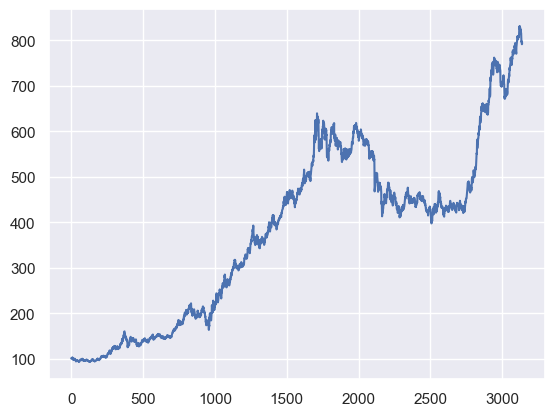

In [48]:
ann_return, history = stock_score(y_train_preds)
print('Annual return:', ann_return)

sns.lineplot( history)

[*********************100%***********************]  1 of 1 completed
Annual return: 22.96221806833394


<Axes: >

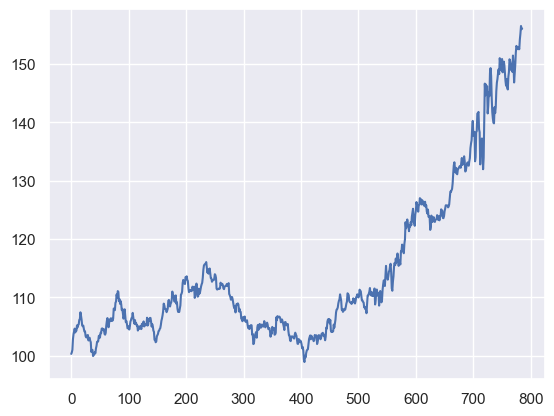

In [49]:
ann_return, history = stock_score(y_test_preds)
print('Annual return:', ann_return)

sns.lineplot( history)